# GDPS 🅱

<style>
  .beta-badge {
    background-color: #f39c12;
    color: white;
    padding: 4px 8px;
    border-radius: 4px;
    font-weight: bold;
  }
</style>

<span class="beta-badge">BETA</span>
<span class="beta-badge">Requires MetPy >=1.6</span>

This demonstrates using data from Canada's GEM Global or Global Deterministic Prediction System (GDPS).

[GDPS Model Description](https://eccc-msc.github.io/open-data/msc-data/nwp_gdps/readme_gdps-datamart_en/#data-location)


**Data Sources**

|`prioriy=`|Data source| Archive Duration|
|--|--|--|
|`"mcs"` | [Meteorological Service of Canada](https://dd.weather.gc.ca/model_gem_global/) | Last 24 hours

**Model Initialization**

Model cyles every twelve hours.

**Forecast Hour**

For the most recent version of GDPS...

|`fxx=`|Forecast lead time|
|--|--|
|`0` through `240`, step=3| 3-hourly forecasts available


**Products**

|`product=`| Product Description |    
|--|--|
|`"15km/grib2/lat_lon"`| Global domain

**Variable and Level**

You will need to specify the variable and level for each request. 

<br>


> **NOTE:** The organization of these files is different than other NWP products.
>
> 1. There are no index files provided.
> 1. Each GRIB2 file only contains one message. The variable name and level is in the file's name.
>
> Herbie requires you provide a keyword argument for both `variable` and `level`. Pay special attention to model description (linked above) to understand how the model data is organized. If you don't provide input for `variable` or `level`, Herbie will give you some ideas. For example, `variable=TMP` and `level=TGL_2` will give you the filename that contains
>
> ```
> TMP_TGL_2
> ```

> **Note:** This requires MetPy version 1.6 or greater which has the capability to parse the _rotated latitude longitude_ map projection type (see [MetPy/#3123](https://github.com/Unidata/MetPy/pull/3123)).


In [1]:
from herbie import Herbie
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
from toolbox import EasyMap, pc
import cartopy.crs as ccrs
import cartopy.feature as feature
import pandas as pd

from matplotlib.patches import Rectangle


recent = pd.Timestamp("now").floor("12h")# - pd.Timedelta("12h")



 ╭─▌▌Herbie─────────────────────────────────────────────╮
 │ WARNING: Unable to create config file               │
 │      /Users/andrew/.config/herbie/config.toml        │
 │ Herbie will use standard default settings.           │
 │ Consider setting env variable HERBIE_CONFIG_PATH.    │
 ╰──────────────────────────────────────────────────────╯



In [2]:
recent

Timestamp('2024-11-16 12:00:00')

In [3]:
H = Herbie(
    recent,  # Datetime
    model="gdps",
    fxx=12,
    variable="PRATE",
    level="SFC_0",
)
H.grib

✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2024-Nov-16 12:00 UTC F12 ┊ GRIB2 @ msc ┊ IDX @ None


'https://dd.weather.gc.ca/model_gem_global/15km/grib2/lat_lon/12/012/CMC_glb_PRATE_SFC_0_latlon.15x.15_2024111612_P012.grib2'

## 500 hPa Geopotential Height and Surface Precipitation

In [4]:
# loading more than one variable requires a loop, because the
# data is stored in multiple files (and a Herbie object only
# represents a single file).

store = []
# 500mb height, total cloud cover, precipitation rate
for var, lev in zip(["HGT", "TCDC", "APCP"], ["ISBL_500", "SFC_0", "SFC_0"]):
    print(var, lev)
    _ds = Herbie(
        recent,
        model="gdps",
        fxx=3,
        variable=var,
        level=lev,
    ).xarray()
    
    # if the variable name is unknown, assign it
    if "unknown" in _ds:
        _ds = _ds.rename({"unknown":var})
    
    store.append(_ds)

ds = xr.merge(store)

HGT ISBL_500
✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2024-Nov-16 12:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


TCDC SFC_0
✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2024-Nov-16 12:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


APCP SFC_0
✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2024-Nov-16 12:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


In [5]:
# slice out only the domain we care about
ds = ds.sel(longitude=slice(-195, -97), latitude=slice(30, 73))

TypeError: 'Bbox' object is not iterable

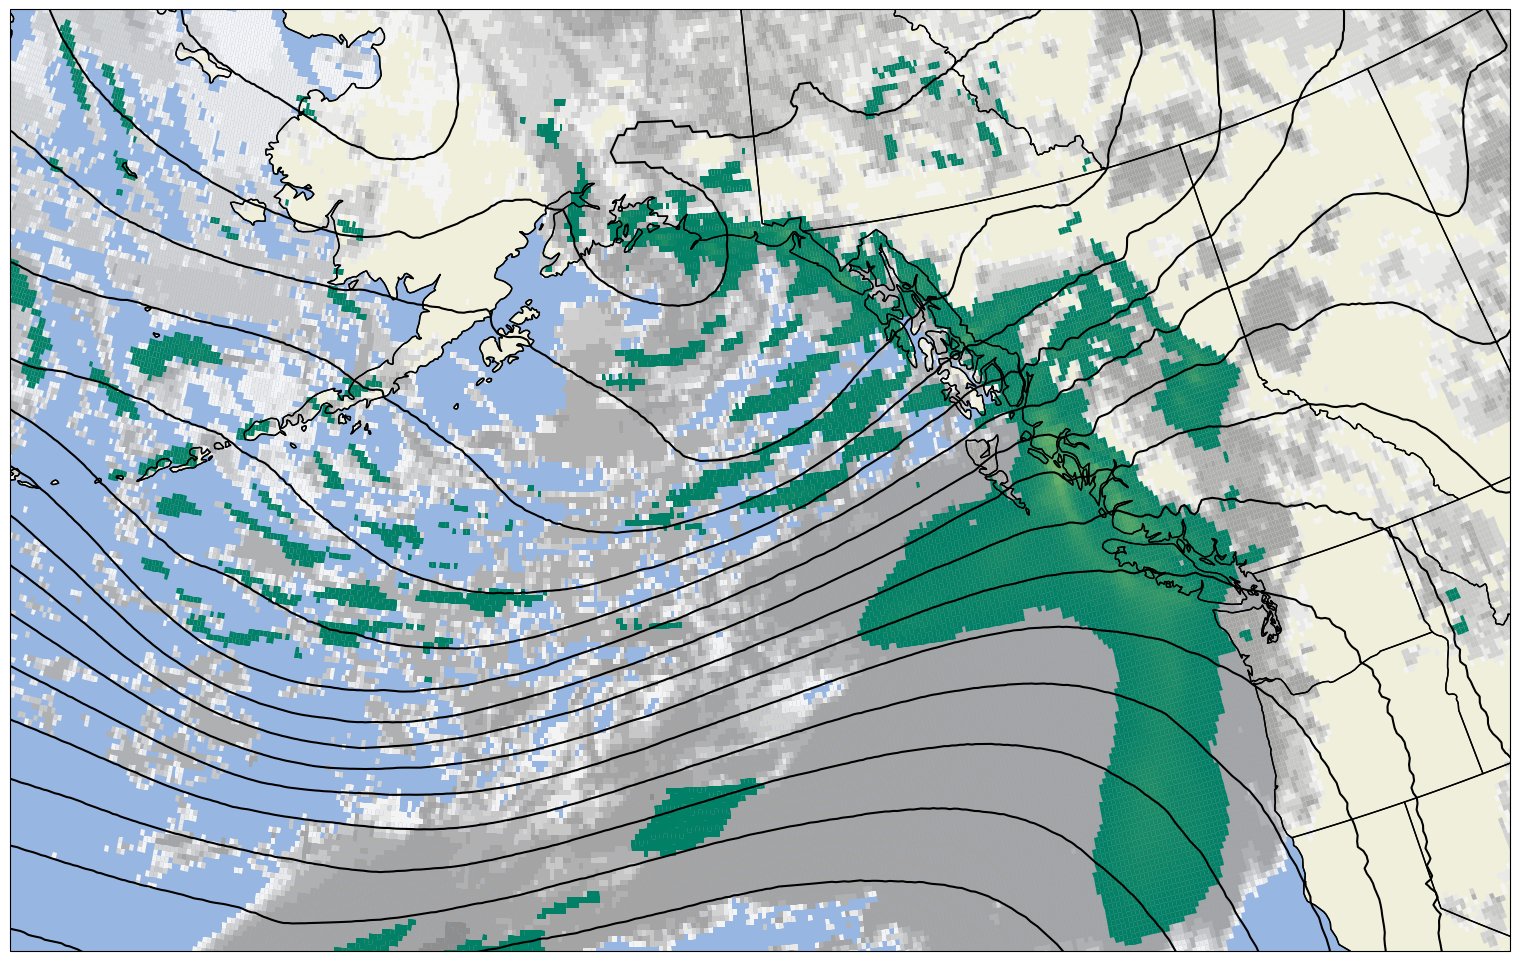

In [22]:
# make a figure
fig = plt.figure(figsize=(15,15))
fig.tight_layout()
ax = fig.add_subplot(1, 1, 1, position=(0,0,1,1), projection=ccrs.LambertConformal(central_longitude=-150, central_latitude=39.0,))
ax.set_extent([-170, -117, 40, 63])

ax.add_feature(feature.LAND)
ax.add_feature(feature.STATES)
ax.add_feature(feature.OCEAN)
ax.add_feature(feature.COASTLINE)

# plot height contours
ax.contour(
    ds.longitude,
    ds.latitude,
    ds.gh,
    colors="k",
    transform=pc,
    levels=range(0, 6000, 50),
)

# plot cloud cover
cc = ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.TCDC.where(ds.TCDC >= 60),
    cmap="binary",
    vmin=60,
    vmax=150,
    antialiased=True,
    transform=pc,
)
#fig.colorbar(cc, ax=ax, shrink=0.08, location="left", pad=-0.05)


# plot precip rate
pr = ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.APCP.where(ds.APCP >= 1),
    cmap="summer",
    vmin=1,
    vmax=50,
    antialiased=True,
    transform=pc,
)




# labels and such
# this is harder than it needs to be. jeez.
s = fig.add_axes([0.0, 0.18601425461212823, 1.0, 0.8139857453878718])
s.get_xaxis().set_visible(False)
s.get_yaxis().set_visible(False)
s.set_facecolor("lightslategray")
s.patch.set_alpha(0.5)

fig.colorbar(pr, ax=ax, shrink=0.25, location="left", pad=-0.05)
